In [12]:
from Bio.PDB import PDBParser,DSSP

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from molecular_data import colors, colorsDSSP, resdict, restype, colorrgba

class MatViewer(object):
    
    visualization_modes = ['cpk','backbone','aminoacid','dssp']
    
    def __init__(self, pdbdata, mode='cpk'):
        
        #Analyze pdb file
        self.parser = PDBParser(QUIET=True,PERMISSIVE=True)
        self.structure = self.parser.get_structure('model',pdbdata)
        
        #DSSP prediction
        self.model = self.structure[0]
        self.dssp = DSSP(self.model, pdbdata)
        
        #Mode selection
        if mode not in MatViewer.visualization_modes:
            raise Exception('Not recognized visualization mode %s' % mode)
        self.mode = mode
        
        #Make the plot
        if self.mode == 'cpk':
            self.cpk2d()
        elif self.mode == 'backbone':
            self.bb2d()
        elif self.mode == 'aminoacid':
            self.aa2d()
        elif self.mode == 'dssp':
            self.dssp2d()
    
    def cpk2d(self):
        """Draws atoms in a CPK colour palette"""
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        for atom_type, color in colors.iteritems():
            atoms = [atom for atom in self.structure.get_atoms() if atom.get_id() == atom_type]
            coordinates = [atom.coord for atom in atoms]
            if not len(atoms)==0:
                x, y, z=zip(*coordinates)
                ax.scatter(x, y, z, c=color, marker='o')
                
        #Select the atoms that are not identified
        atoms_1 = [atom for atom in self.structure.get_atoms()]
        atoms_2 = [atom for atom in self.structure.get_atoms() if atom.get_id() in colors.keys()]
        atoms_pink = list(set(atoms_1)-set(atoms_2))
        
        coordinates_pink = [atom.coord for atom in atoms_pink]
        xp, yp, zp = zip(*coordinates_pink)
        ax.scatter(xp, yp, zp, c='pink', marker='o')
        
        ax.axis("off")
        plt.show()
    
    def bb2d(self):
        """Draws CA-N atoms linked by lines"""
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        for chain in self.structure.get_chains():
            can_atoms = [atom for atom in chain.get_atoms() if atom.get_name() == 'CA' or atom.get_name() == 'N']
            can_coordinates = [atom.coord for atom in can_atoms]
            x,y,z=zip(*can_coordinates)
            ccolor = np.random.rand(3,1)
            
            ax.plot(x, y, z, c=ccolor, linewidth=2)
            ax.scatter(x, y, z, c=ccolor, marker='o')
        
        ax.axis("off")
        plt.show()
    
    def aa2d(self):
        """Draws atoms using a colour palette depending on the type of residue"""
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        #Select residues only if they're aminoacids
        for resname, residuetype in resdict.iteritems():
            residues = [residue for residue in self.structure.get_residues() if residue.get_resname() == resname]
            rescoord = []
            color = colorrgba(residuetype)
            
            for residue in residues:
                atoms = [atom for atom in residue.get_atoms()]
                coordinates = [atom.coord for atom in atoms]
                rescoord.append(np.array(coordinates))
                
            if len(rescoord)>1:
                rescoord = np.concatenate(rescoord)
                
            if not len(residues)==0:
                x, y, z =zip(*rescoord)
                ax.scatter(x, y, z, c=color, marker='o')

        #Select residues that are not aminoacids, skipping water
        residues_1 = [residue for residue in self.structure.get_residues() if residue.get_resname() != 'HOH']
        residues_2 = [residue for residue in self.structure.get_residues() if residue.get_resname() in resdict.keys()]
        
        residues_pink = list(set(residues_1)-set(residues_2))
        rescoordpink = []
        
        for residue in residues_pink:
            atomspink = [atom for atom in residue.get_atoms()]
            coordinatespink = [atom.coord for atom in atomspink]
            rescoordpink.append(np.array(coordinatespink))
        
        if len(rescoordpink)>1:
            rescoordpink = np.concatenate(rescoordpink)
        
        xp, yp, zp = zip(*rescoordpink)
        ax.scatter(xp, yp, zp, c='pink', marker='o')
        
        ax.axis("off")
        plt.show()

    def dssp2d(self):
        """Draw CA-N atoms linked by lines, coloured by their tertiary structure prediction"""
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        #Create the residue lists linked to their predictions
        residues = [residue for residue in self.structure.get_residues() if residue.get_resname() in resdict.keys()]
        struct3 = [self.dssp[key][2] for key in list(self.dssp.keys())]
        respred = zip(struct3,residues)
        
        #Create the point cloud depending on the prediction
        for prediction, color in colorsDSSP.iteritems():
            residuesp = [residue[1] for residue in respred if residue[0] == prediction]
            
            predcoord_can = []
            for residue in residuesp:
                atomsp = [atom for atom in residue.get_atoms() if atom.get_name() == 'CA' or atom.get_name() == 'N']
                coordinatesp = [atom.coord for atom in atomsp]
                predcoord_can.append(np.array(coordinatesp))
                
            if len(predcoord_can)>1:
                predcoord_can = np.concatenate(predcoord_can)
                
            if not len(residuesp)==0:
                x, y, z = zip(*predcoord_can)
                ax.scatter(x, y, z, c=color, marker='o')
            
        #Creamos las cadenas que unen los atomos
        for chain in self.structure.get_chains():
            can_atoms = [atom for atom in chain.get_atoms() if atom.get_name() == 'CA' or atom.get_name() == 'N']
            can_coordinates = [atom.coord for atom in can_atoms]
            x, y, z = zip(*can_coordinates)
            ccolor = np.random.rand(3,1)
            ax.plot(x, y, z, c=ccolor, linewidth=1)
            
        ax.axis("off")
        plt.show()

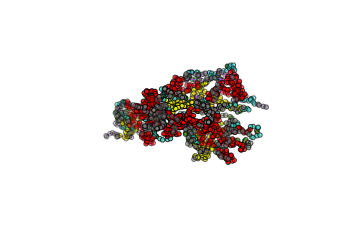

In [15]:
MatViewer('data/1yd9.pdb',mode='dssp')